## <div align='center'><b>Advanced Text Analysis on News Data Using Python: Sentiment and Emotion Detection</b></div>

This project demonstrates (Part2: A):
> 1. Data cleaning and normalization.

> 2. Traditional sentiment analysis using TextBlob.

> 3. Advanced sentiment analysis using VADER and Afinn.

> 4. Emotion extraction using Text2Emotion.

> 5. Visualization with word clouds and distribution plots.

> 6. Vectorization using CountVectorizer and TF-IDF.

In [8]:
pip install flair

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install ipywidgets --upgrade
jupyter nbextension enable --py widgetsnbextension

SyntaxError: invalid syntax (1267767315.py, line 1)

In [1]:
import pandas as pd
import re
import nltk
import text2emotion as te
from afinn import Afinn
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data cleaning and normalization

In [3]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('stopwords')

# Read the scraped articles CSV file (ensure the file exists)
df = pd.read_csv("bbc_article_mechanicalsoup.csv")

# Define a function to clean text: lowercase, remove numbers, punctuation, and extra whitespace.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the "content" column
df['clean_content'] = df['content'].astype(str).apply(clean_text)

# Remove stopwords from the cleaned text
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

df['clean_content'] = df['clean_content'].apply(remove_stopwords)

# Save the cleaned data if needed
df.to_csv("bbc_articles_cleaned.csv", index=False)
print("Data cleaning and normalization completed.")

Data cleaning and normalization completed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\300407353\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('bbc_news_articles_bs.csv')
df.head()

,title,url,content
0,NewsNews,https://www.bbc.com/news/topics/c2vdnvdg6xxt,"Hamas releases three more Israelis, as 369 Pal..."
1,NewsNews,https://www.bbc.com/news/war-in-ukraine,"Elsewhere, European leaders are preparing for ..."
2,NewsNews,https://www.bbc.com/news/us-canada,US-Israeli talks follow President Trump's prop...
3,NewsNews,https://www.bbc.com/news/uk,Business Secretary Jonathan Reynolds says the ...
4,NewsNews,https://www.bbc.com/news/world/africa,Some people cheered as the fighters entered th...


In [4]:
df['cleaned_content'] = df['content'].apply(clean_text)
df.head(3)

,title,url,content,cleaned_content
0,NewsNews,https://www.bbc.com/news/topics/c2vdnvdg6xxt,"Hamas releases three more Israelis, as 369 Pal...",hama releas three isra palestinian hand sixth ...
1,NewsNews,https://www.bbc.com/news/war-in-ukraine,"Elsewhere, European leaders are preparing for ...",elsewher european leader prepar emerg summit f...
2,NewsNews,https://www.bbc.com/news/us-canada,US-Israeli talks follow President Trump's prop...,usisra talk follow presid trump propos wide co...


### Traditional Sentiment Analysis using TextBlob

In [12]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd

# Load scraped articles from CSV
df = pd.read_csv("bbc_article_mechanicalsoup.csv")

# Initialize Flair sentiment classifier
classifier = TextClassifier.load('en-sentiment')

def flair_sentiment(text):
    sentence = Sentence(text)
    classifier.predict(sentence)
    # The classifier returns a label (e.g., POSITIVE) with a score.
    if sentence.labels:
        score = sentence.labels[0].score
        label = sentence.labels[0].value
        # For a directional score, we assign positive for "POSITIVE", negative for "NEGATIVE"
        directional_score = score if label == "POSITIVE" else -score
        return directional_score, label
    else:
        return 0, "neutral"

# Apply the function to each article's content.
df[['flair_score', 'flair_label']] = df['content'].apply(lambda x: pd.Series(flair_sentiment(x)))

# Save results
df.to_csv("bbc_articles_flair_sentiment.csv", index=False)
print("Flair sentiment analysis completed.")

2025-03-10 14:07:40,579 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to C:\Users\300407~1\AppData\Local\Temp\tmp9mdvgj8f


100%|███████████████████████████████████████████████████████████████████████████████| 253M/253M [00:16<00:00, 16.3MB/s]

2025-03-10 14:07:57,417 copying C:\Users\300407~1\AppData\Local\Temp\tmp9mdvgj8f to cache at C:\Users\300407353\.flair\models\sentiment-en-mix-distillbert_4.pt


2025-03-10 14:07:57,556 removing temp file C:\Users\300407~1\AppData\Local\Temp\tmp9mdvgj8f


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Flair sentiment analysis completed.


## Advanced Sentiment Analysis using VADER

In [6]:
sia = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_category'] = df['cleaned_content'].apply(vader_sentiment)
df.head(2)

,title,url,content,cleaned_content,sentiment,sentiment_category,vader_category
0,NewsNews,https://www.bbc.com/news/topics/c2vdnvdg6xxt,"Hamas releases three more Israelis, as 369 Pal...",hama releas three isra palestinian hand sixth ...,0.036317,Positive,Negative
1,NewsNews,https://www.bbc.com/news/war-in-ukraine,"Elsewhere, European leaders are preparing for ...",elsewher european leader prepar emerg summit f...,0.093267,Positive,Negative


## Advanced Sentiment Analysis using Afinn

In [7]:
afinn = Afinn()
df['afinn_score'] = df['cleaned_content'].apply(lambda x: afinn.score(x))
df['afinn_category'] = df['afinn_score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)
df.head(2)

,title,url,content,cleaned_content,sentiment,sentiment_category,vader_category,afinn_score,afinn_category
0,NewsNews,https://www.bbc.com/news/topics/c2vdnvdg6xxt,"Hamas releases three more Israelis, as 369 Pal...",hama releas three isra palestinian hand sixth ...,0.036317,Positive,Negative,-38.0,Negative
1,NewsNews,https://www.bbc.com/news/war-in-ukraine,"Elsewhere, European leaders are preparing for ...",elsewher european leader prepar emerg summit f...,0.093267,Positive,Negative,-15.0,Negative


## Emotion Extraction using Text2Emotion

In [8]:
def extract_emotions_parallel(texts):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(te.get_emotion, texts))
    return results
df['News_emotions'] = extract_emotions_parallel(df['cleaned_content'].tolist())
df.head(2)

,title,url,content,cleaned_content,sentiment,sentiment_category,vader_category,afinn_score,afinn_category,News_emotions
0,NewsNews,https://www.bbc.com/news/topics/c2vdnvdg6xxt,"Hamas releases three more Israelis, as 369 Pal...",hama releas three isra palestinian hand sixth ...,0.036317,Positive,Negative,-38.0,Negative,"{'Happy': 0.24, 'Angry': 0.07, 'Surprise': 0.1..."
1,NewsNews,https://www.bbc.com/news/war-in-ukraine,"Elsewhere, European leaders are preparing for ...",elsewher european leader prepar emerg summit f...,0.093267,Positive,Negative,-15.0,Negative,"{'Happy': 0.07, 'Angry': 0.05, 'Surprise': 0.3..."


## Visualization

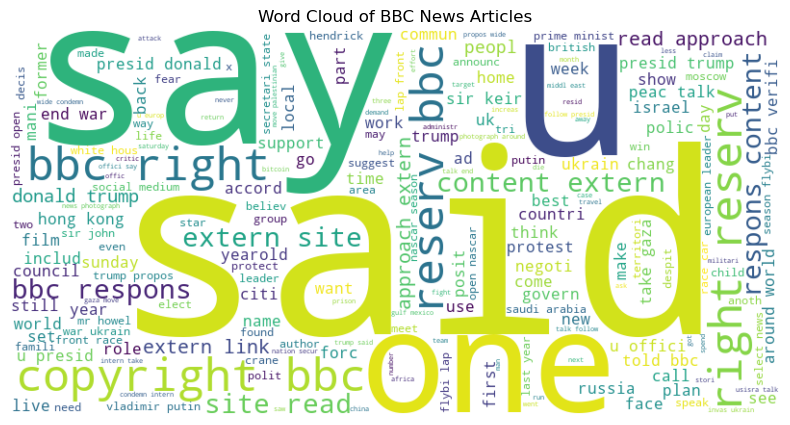

In [9]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_content']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of BBC News Articles")
plt.show()

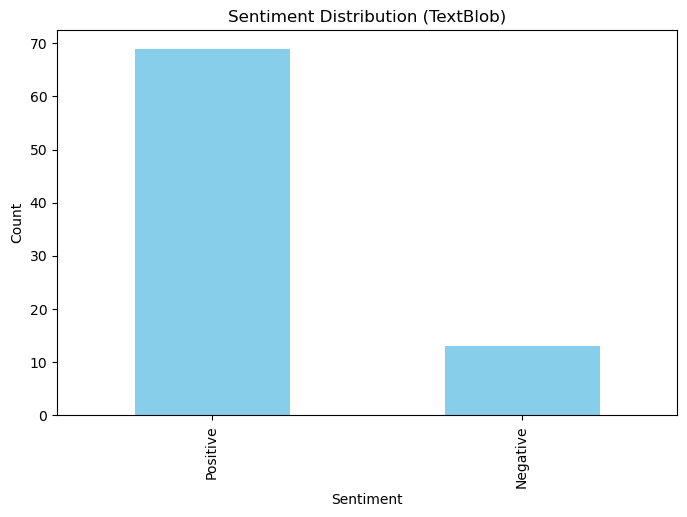

In [10]:
# Plot Sentiment Distribution (TextBlob)
plt.figure(figsize=(8, 5))
df['sentiment_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Sentiment Distribution (TextBlob)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

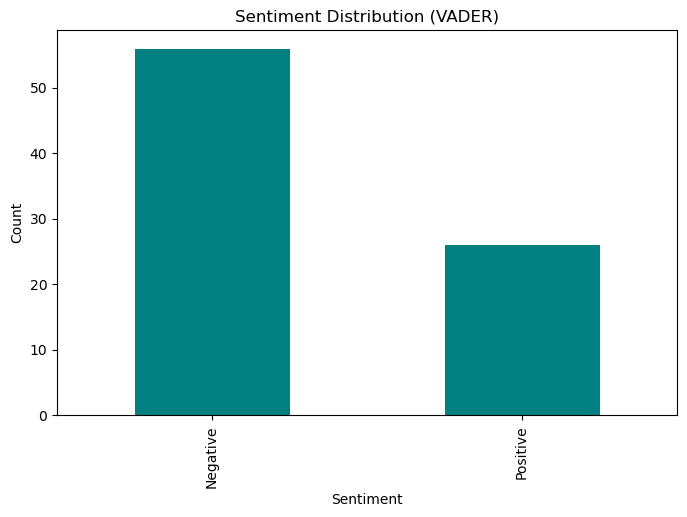

In [11]:
# Plot Sentiment Distribution (VADER)
plt.figure(figsize=(8, 5))
df['vader_category'].value_counts().plot(kind='bar', color='teal')
plt.title("Sentiment Distribution (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

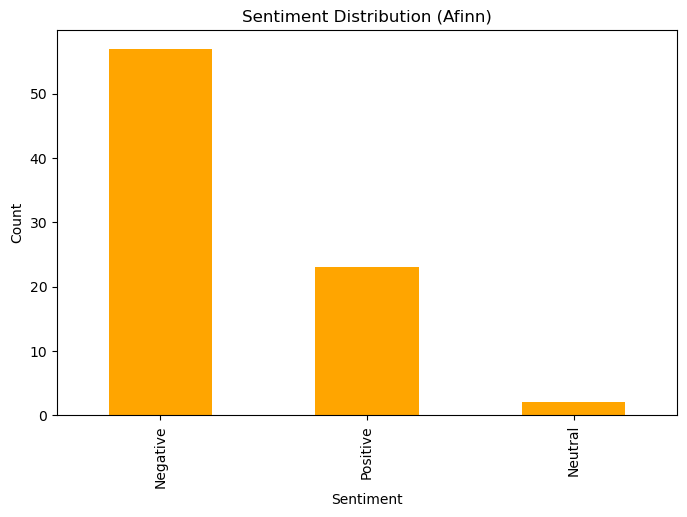

In [12]:
# Plot Sentiment Distribution (Afinn)
plt.figure(figsize=(8, 5))
df['afinn_category'].value_counts().plot(kind='bar', color='orange')
plt.title("Sentiment Distribution (Afinn)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

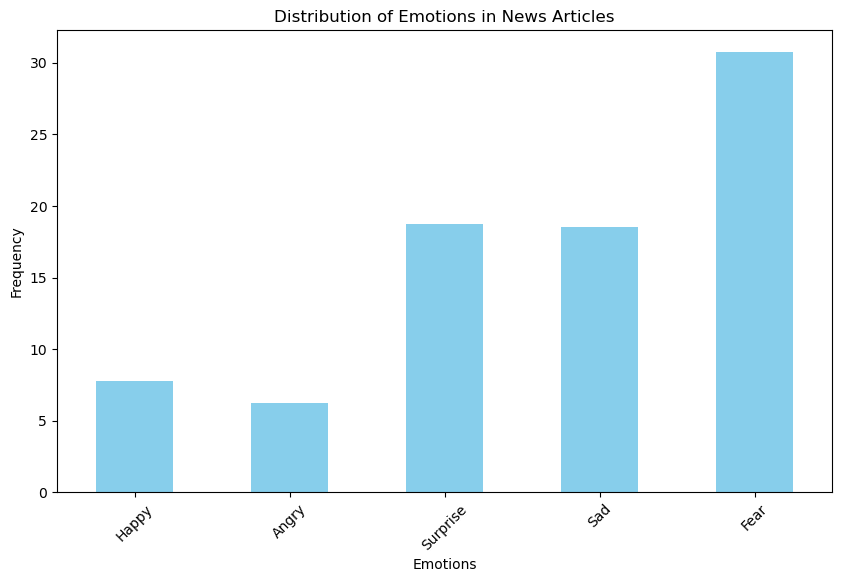

In [13]:
emotions_df = pd.json_normalize(df['News_emotions'])
# Sum up all emotions across the dataset
emotion_sums = emotions_df.sum(axis=0)
# Plotting
plt.figure(figsize=(10, 6))
emotion_sums.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions in News Articles')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Vectorization using CountVectorizer and TF-IDF.

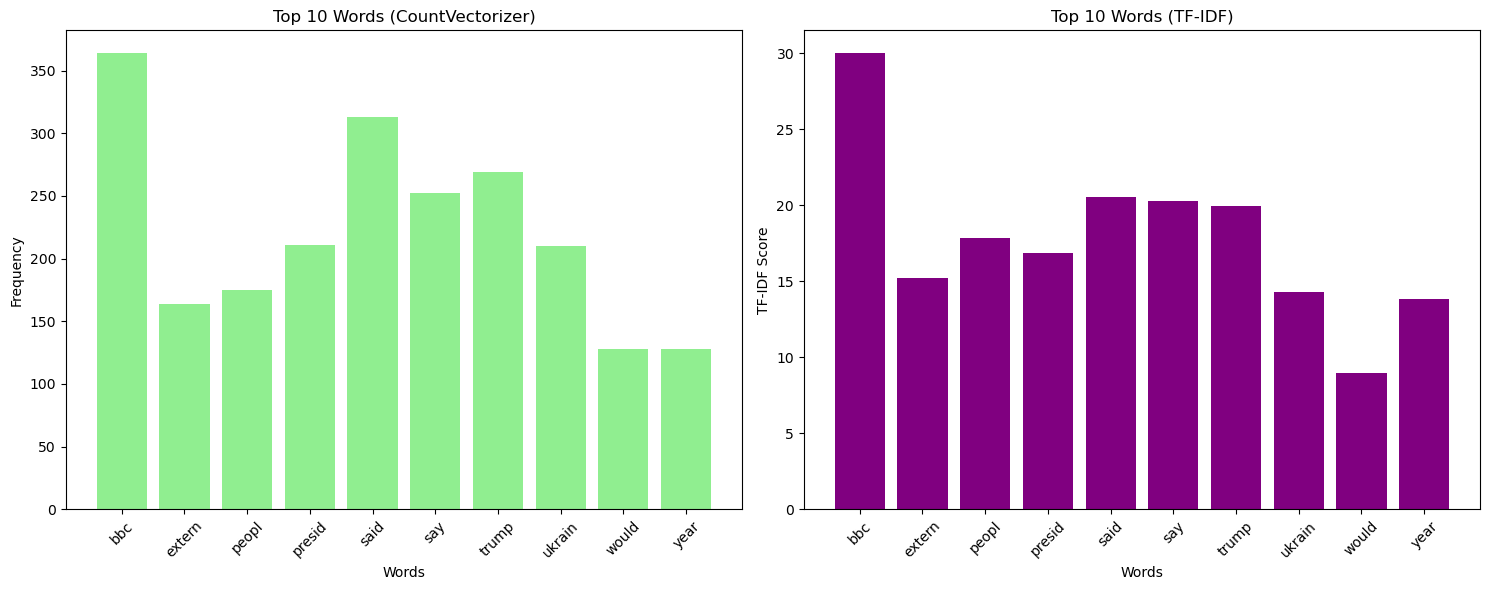

In [14]:
count_vectorizer = CountVectorizer(max_features=10)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
count_matrix = count_vectorizer.fit_transform(df['cleaned_content'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_content'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot Top Words from CountVectorizer
axes[0].bar(count_vectorizer.get_feature_names_out(), count_matrix.toarray().sum(axis=0), color='lightgreen')
axes[0].set_title("Top 10 Words (CountVectorizer)")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)
# Plot Top Words from TF-IDF
axes[1].bar(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray().sum(axis=0), color='purple')
axes[1].set_title("Top 10 Words (TF-IDF)")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("TF-IDF Score")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Save Processed Data 

In [15]:
df.to_csv('bbc_news_articles_text_analysis_advanced.csv', index=False)

In [16]:
preview_cols = ['title', 'sentiment_category', 'vader_category', 'afinn_category', 'News_emotions']
(df[preview_cols].head(10))

,title,sentiment_category,vader_category,afinn_category,News_emotions
0,NewsNews,Positive,Negative,Negative,"{'Happy': 0.24, 'Angry': 0.07, 'Surprise': 0.1..."
1,NewsNews,Positive,Negative,Negative,"{'Happy': 0.07, 'Angry': 0.05, 'Surprise': 0.3..."
2,NewsNews,Negative,Negative,Negative,"{'Happy': 0.0, 'Angry': 0.02, 'Surprise': 0.28..."
3,NewsNews,Positive,Positive,Positive,"{'Happy': 0.18, 'Angry': 0.14, 'Surprise': 0.0..."
4,NewsNews,Positive,Negative,Negative,"{'Happy': 0.15, 'Angry': 0.22, 'Surprise': 0.0..."
5,NewsNews,Positive,Negative,Negative,"{'Happy': 0.11, 'Angry': 0.02, 'Surprise': 0.3..."
6,NewsNews,Positive,Positive,Positive,"{'Happy': 0.15, 'Angry': 0.1, 'Surprise': 0.2,..."
7,NewsNews,Positive,Negative,Negative,"{'Happy': 0.1, 'Angry': 0.08, 'Surprise': 0.31..."
8,NewsNews,Positive,Negative,Negative,"{'Happy': 0.08, 'Angry': 0.08, 'Surprise': 0.1..."
9,NewsNews,Negative,Negative,Negative,"{'Happy': 0.17, 'Angry': 0.12, 'Surprise': 0.0..."


# <div align='center'><b>Conclusion:</b></div>
This project implemented multiple text analysis techniques on BBC News articles:
- **TextBlob** for polarity-based sentiment classification.
- **VADER** for rule-based sentiment analysis, especially effective for social media.
- **Afinn** for lexicon-based sentiment scoring.
- **Text2Emotion** for extracting core emotions.

Comparison Table:
| Algorithm       | Strengths                           | Limitations                          |
|-----------------|------------------------------------|--------------------------------------|
| TextBlob        | Simple, quick polarity detection   | Limited contextual accuracy          |
| VADER           | Great for short texts, emoji-aware | Less effective on long formal text   |
| Afinn           | Fast, lexicon-based scores         | No context awareness                 |
| Text2Emotion    | Detects multiple emotions          | Dependent on predefined lexicon      |
